<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Making an RGB Satellite Composite</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="https://unidata.github.io/MetPy/latest/_images/sphx_glr_GINI_Water_Vapor_001.png" alt="Example Satellite Image" style="height: 500px;"></div>


## Overview:

* **Teaching:** 20 minutes
* **Exercises:** None

### Questions
1. How can array manipulation be used with imagery data?
2. How can multiple channels of data be combined into an RGB image?
3. How can complex functionality be broken up into smaller reuseable and encapsulated functions?

### Objectives
1. Download satellite data with Siphon
2. Parse out netCDF file
3. Reshape and resample data channels to identical sizes
4. Create an RGB composite

Color images consist of red, green, and blue components. We can utilize the red and blue channels of the GOES-16 satellite, along with the “veggie” band to create a color image of the Earth. GOES-16 does not have a sensor that strictly covers the green visible range, so the image would be too green. Currently lookup tables are being created to simulate a true green sensor on the platform. Until those are completed, we will use an approximation that does a good job of producing a near real-color image. We'll also implement a square-root brightness enhancement.

We’ll need to accomplish a few tasks - making an outline like this is a good way to start thinking of how your program can be broken up into functions that encapsulate different functionality.

* Get three channels of satellite data
* Resample the red channel to match the resolution of the other channels
* Combine the RGB channels into a single multi-dimensional array
* Create the image


In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from matplotlib import patheffects
from metpy.plots import add_metpy_logo
import numpy as np
from scipy import interpolate
from siphon.catalog import TDSCatalog

%matplotlib inline

In [2]:
def open_dataset(date, channel, region, idx):
    """
    Open and return a netCDF Dataset object for a given date, channel, and image index
    of GOES-16 data from THREDDS test server.
    """
    cat = TDSCatalog('http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/'
                 '{}/Channel{:02d}/{:%Y%m%d}/catalog.xml'.format(region, channel, date))
    ds = cat.datasets[idx]
    return ds.remote_access(service='OPENDAP')

In [3]:
def interpolate_red_channel(red_ds, resampled_ds):
    """
    Interpolate the red data channel to the same grid as another channel.
    """
    x_new = resampled_ds.variables['x'][:]
    y_new = resampled_ds.variables['y'][:]

    f = interpolate.interp2d(red_ds.variables['x'][:], red_ds.variables['y'][:],
                             red_ds.variables['Sectorized_CMI'][:], fill_value=0)
    red_interpolated = f(x_new, y_new) 
    return x_new, y_new, red_interpolated[::-1]

In [4]:
def make_RGB_data(date, region, idx):
    """
    Make an RGB image array, returning the time, coordinates, projection, and data.
    """
    red_channel = 2
    green_channel = 3
    blue_channel = 1
                         
    red_ds = open_dataset(date, red_channel, region, idx)
    blue_ds = open_dataset(date, blue_channel, region, idx)
    green_ds = open_dataset(date, green_channel, region, idx)
                         
    green_data = green_ds.variables['Sectorized_CMI'][:]
    blue_data = blue_ds.variables['Sectorized_CMI'][:]

    x, y, red_data = interpolate_red_channel(red_ds, blue_ds)
    
    # Clip out maxes
    red_data[np.where(red_data <= 0.0001)] = 1
    blue_data[np.where(blue_data <= 0.0001)] = 1
    green_data[np.where(green_data <= 0.0001)] = 1

    # Brightness Enhancement
    red_data = np.sqrt(red_data)
    blue_data = np.sqrt(blue_data)
    green_data = np.sqrt(green_data)

    # Make better fake green channel
    green_data = green_data * 0.1 + blue_data * 0.45 + red_data * 0.45
    
    rgb_data = np.dstack([red_data, green_data, blue_data])

    x = green_ds.variables['x'][:]
    y = green_ds.variables['y'][:]  
    proj_var = green_ds.variables[green_ds.variables['Sectorized_CMI'].grid_mapping]

    time = datetime.strptime(green_ds.start_date_time, '%Y%j%H%M%S')
    
    return time, x, y, proj_var, rgb_data

In [5]:
# Get the next to most recent image and make the RGB data array.
date = datetime.utcnow()
timestamp, x, y, proj_var, rgb_data = make_RGB_data(date, 'Mesoscale-1', -2)

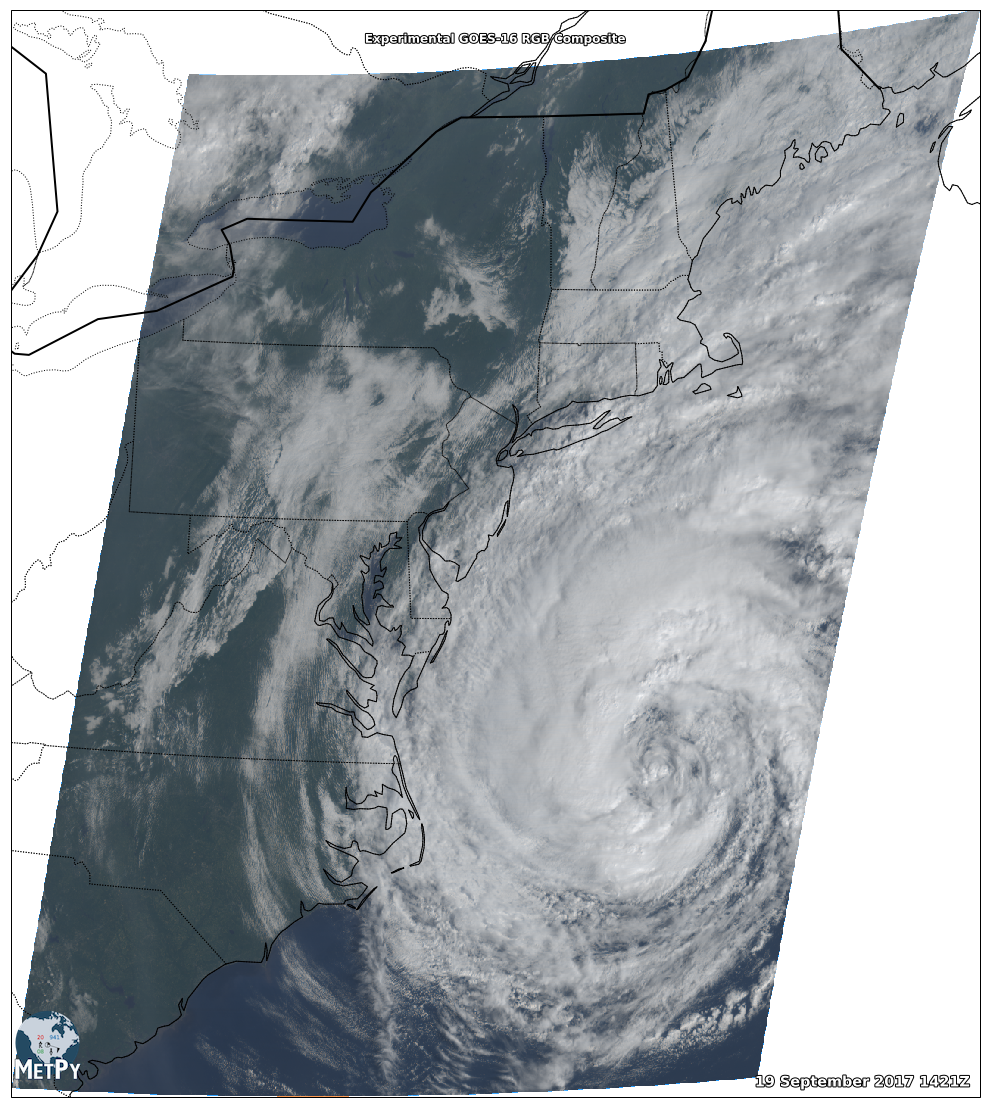

In [6]:
# Create a Globe specifying a spherical earth with the correct radius
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.semi_major,
                   semiminor_axis=proj_var.semi_minor)

# Select the correct projection.

proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                             central_latitude=proj_var.latitude_of_projection_origin,
                             standard_parallels=[proj_var.standard_parallel],
                             globe=globe)

#proj = ccrs.Mercator(central_longitude=proj_var.longitude_of_projection_origin, 
#                     latitude_true_scale=proj_var.standard_parallel,
#                     globe=globe)

# Set up a feature for the state/province lines. Tell cartopy not to fill in the polygons
state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lakes',
                                             scale='50m', facecolor='none')

# Same as before, except we call imshow with our colormap and norm.
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=proj)

im = ax.imshow(rgb_data, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper')
ax.coastlines(resolution='50m', color='black')
ax.add_feature(state_boundaries, linestyle=':', edgecolor='black')
ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

# Add text (aligned to the right); save the returned object so we can manipulate it.
text_time = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
               horizontalalignment='right', transform=ax.transAxes,
               color='white', fontsize='x-large', weight='bold')

text_channel = ax.text(0.5, 0.97, 'Experimental GOES-16 RGB Composite',
               horizontalalignment='center', transform=ax.transAxes,
               color='white', fontsize='large', weight='bold')

# Make the text stand out even better using matplotlib's path effects
outline_effect = [patheffects.withStroke(linewidth=2, foreground='black')]
text_time.set_path_effects(outline_effect)
text_channel.set_path_effects(outline_effect)

# Add the MetPy Logo
fig = add_metpy_logo(fig)